# Programming Assignment 2

## Introduction

This assignment's purpose is to familiarize ourselves with designing and programming algorithms to search and select the most optimal paths to get to a specific goal using a heuristic function.

The goal for this assignment is to design and create such algorithms for two different environments.

## Theoretical Background

The approach used to solve the problems for this assignment are that of informed search. In informed search we use information specific to the problem to find more efficient solutions than may be possible when using uninformed search. To accomplish this goal, informed search algorithms make use of a heuristic functions. A heuristic function helps the search algorithm make a prediction about the cost of certain paths within the search. Different problems require heurisitc functions which are specific to the problem. 

## Discusion

If we were to assume that every possible (x,y) pair on the plane is valid, then there are an infinite number of states, and if there's an infinite number of states, then the number of paths it could take is infinite. This is because the slightest change in position, no matter how small it is, can be considered a new (x,y). in example (3.0,2.0) and (3.000150,2.60) are two different pairs even though they are relatively close to each other.

However, there can still only be one optimal path in the infinite realm of possibility. The most optimal path in a flat environment is taking the most straight line along the vertexes towards the goal.

In example, here is a rectangular triangle

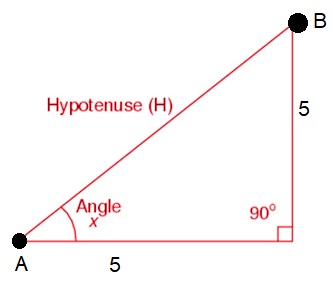

If we have to go from A to B. Walking through both legs, we'd have to walk 5 units to the right, then 5 units upwards to the goal, totaling 10 units travelled. But if we were to walk in a straight line through the hypotenuse, we'd walk a total of ~7.07 units instead.

Knowing that the shortest path would be taking the straightest line, the state space could be trimmed down to just the vertexes of the obstacles, this will also reduce the possible paths to the goal; thus both the state space, and the paths are finite.

The state space is all (x,y) positions that are in an obstacle's vertex, being only as large as the total amount of vertexes in all of the obstacles in the plane.

This code is based on the search algorithsm developed on https://github.com/aimacode/aima-python/blob/master/search.py by its collaborators

In [1]:
"""Provides some utilities widely used by other modules"""

import bisect
import collections
import collections.abc
import functools
import heapq
import operator
import os.path
import random
from itertools import chain, combinations
from statistics import mean

import numpy as np


# ______________________________________________________________________________
# Functions on Sequences and Iterables


def sequence(iterable):
    """Converts iterable to sequence, if it is not already one."""
    return iterable if isinstance(iterable, collections.abc.Sequence) else tuple([iterable])


def remove_all(item, seq):
    """Return a copy of seq (or string) with all occurrences of item removed."""
    if isinstance(seq, str):
        return seq.replace(item, '')
    elif isinstance(seq, set):
        rest = seq.copy()
        rest.remove(item)
        return rest
    else:
        return [x for x in seq if x != item]


def unique(seq):
    """Remove duplicate elements from seq. Assumes hashable elements."""
    return list(set(seq))


def count(seq):
    """Count the number of items in sequence that are interpreted as true."""
    return sum(map(bool, seq))


def multimap(items):
    """Given (key, val) pairs, return {key: [val, ....], ...}."""
    result = collections.defaultdict(list)
    for (key, val) in items:
        result[key].append(val)
    return dict(result)


def multimap_items(mmap):
    """Yield all (key, val) pairs stored in the multimap."""
    for (key, vals) in mmap.items():
        for val in vals:
            yield key, val


def product(numbers):
    """Return the product of the numbers, e.g. product([2, 3, 10]) == 60"""
    result = 1
    for x in numbers:
        result *= x
    return result


def first(iterable, default=None):
    """Return the first element of an iterable; or default."""
    return next(iter(iterable), default)


def is_in(elt, seq):
    """Similar to (elt in seq), but compares with 'is', not '=='."""
    return any(x is elt for x in seq)


def mode(data):
    """Return the most common data item. If there are ties, return any one of them."""
    [(item, count)] = collections.Counter(data).most_common(1)
    return item


def power_set(iterable):
    """power_set([1,2,3]) --> (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"""
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s) + 1)))[1:]


def extend(s, var, val):
    """Copy dict s and extend it by setting var to val; return copy."""
    return {**s, var: val}


def flatten(seqs):
    return sum(seqs, [])


# ______________________________________________________________________________
# argmin and argmax

identity = lambda x: x


def argmin_random_tie(seq, key=identity):
    """Return a minimum element of seq; break ties at random."""
    return min(shuffled(seq), key=key)


def argmax_random_tie(seq, key=identity):
    """Return an element with highest fn(seq[i]) score; break ties at random."""
    return max(shuffled(seq), key=key)


def shuffled(iterable):
    """Randomly shuffle a copy of iterable."""
    items = list(iterable)
    random.shuffle(items)
    return items


# ______________________________________________________________________________
# Statistical and mathematical functions


def histogram(values, mode=0, bin_function=None):
    """Return a list of (value, count) pairs, summarizing the input values.
    Sorted by increasing value, or if mode=1, by decreasing count.
    If bin_function is given, map it over values first."""
    if bin_function:
        values = map(bin_function, values)

    bins = {}
    for val in values:
        bins[val] = bins.get(val, 0) + 1

    if mode:
        return sorted(list(bins.items()), key=lambda x: (x[1], x[0]), reverse=True)
    else:
        return sorted(bins.items())


def dot_product(x, y):
    """Return the sum of the element-wise product of vectors x and y."""
    return sum(_x * _y for _x, _y in zip(x, y))


def element_wise_product(x, y):
    """Return vector as an element-wise product of vectors x and y."""
    assert len(x) == len(y)
    return np.multiply(x, y)


def matrix_multiplication(x, *y):
    """Return a matrix as a matrix-multiplication of x and arbitrary number of matrices *y."""

    result = x
    for _y in y:
        result = np.matmul(result, _y)

    return result


def vector_add(a, b):
    """Component-wise addition of two vectors."""
    return tuple(map(operator.add, a, b))


def scalar_vector_product(x, y):
    """Return vector as a product of a scalar and a vector"""
    return np.multiply(x, y)


def probability(p):
    """Return true with probability p."""
    return p > random.uniform(0.0, 1.0)


def weighted_sample_with_replacement(n, seq, weights):
    """Pick n samples from seq at random, with replacement, with the
    probability of each element in proportion to its corresponding
    weight."""
    sample = weighted_sampler(seq, weights)
    return [sample() for _ in range(n)]


def weighted_sampler(seq, weights):
    """Return a random-sample function that picks from seq weighted by weights."""
    totals = []
    for w in weights:
        totals.append(w + totals[-1] if totals else w)
    return lambda: seq[bisect.bisect(totals, random.uniform(0, totals[-1]))]


def weighted_choice(choices):
    """A weighted version of random.choice"""
    # NOTE: should be replaced by random.choices if we port to Python 3.6

    total = sum(w for _, w in choices)
    r = random.uniform(0, total)
    upto = 0
    for c, w in choices:
        if upto + w >= r:
            return c, w
        upto += w


def rounder(numbers, d=4):
    """Round a single number, or sequence of numbers, to d decimal places."""
    if isinstance(numbers, (int, float)):
        return round(numbers, d)
    else:
        constructor = type(numbers)  # Can be list, set, tuple, etc.
        return constructor(rounder(n, d) for n in numbers)


def num_or_str(x):  # TODO: rename as `atom`
    """The argument is a string; convert to a number if possible, or strip it."""
    try:
        return int(x)
    except ValueError:
        try:
            return float(x)
        except ValueError:
            return str(x).strip()


def euclidean_distance(x, y):
    return np.sqrt(sum((_x - _y) ** 2 for _x, _y in zip(x, y)))


def manhattan_distance(x, y):
    return sum(abs(_x - _y) for _x, _y in zip(x, y))


def hamming_distance(x, y):
    return sum(_x != _y for _x, _y in zip(x, y))


def cross_entropy_loss(x, y):
    return (-1.0 / len(x)) * sum(_x * np.log(_y) + (1 - _x) * np.log(1 - _y) for _x, _y in zip(x, y))


def mean_squared_error_loss(x, y):
    return (1.0 / len(x)) * sum((_x - _y) ** 2 for _x, _y in zip(x, y))


def rms_error(x, y):
    return np.sqrt(ms_error(x, y))


def ms_error(x, y):
    return mean((_x - _y) ** 2 for _x, _y in zip(x, y))


def mean_error(x, y):
    return mean(abs(_x - _y) for _x, _y in zip(x, y))


def mean_boolean_error(x, y):
    return mean(_x != _y for _x, _y in zip(x, y))


def normalize(dist):
    """Multiply each number by a constant such that the sum is 1.0"""
    if isinstance(dist, dict):
        total = sum(dist.values())
        for key in dist:
            dist[key] = dist[key] / total
            assert 0 <= dist[key] <= 1  # probabilities must be between 0 and 1
        return dist
    total = sum(dist)
    return [(n / total) for n in dist]


def random_weights(min_value, max_value, num_weights):
    return [random.uniform(min_value, max_value) for _ in range(num_weights)]


def sigmoid(x):
    """Return activation value of x with sigmoid function."""
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(value):
    return value * (1 - value)


def elu(x, alpha=0.01):
    return x if x > 0 else alpha * (np.exp(x) - 1)


def elu_derivative(value, alpha=0.01):
    return 1 if value > 0 else alpha * np.exp(value)


def tanh(x):
    return np.tanh(x)


def tanh_derivative(value):
    return 1 - (value ** 2)


def leaky_relu(x, alpha=0.01):
    return x if x > 0 else alpha * x


def leaky_relu_derivative(value, alpha=0.01):
    return 1 if value > 0 else alpha


def relu(x):
    return max(0, x)


def relu_derivative(value):
    return 1 if value > 0 else 0


def step(x):
    """Return activation value of x with sign function"""
    return 1 if x >= 0 else 0


def gaussian(mean, st_dev, x):
    """Given the mean and standard deviation of a distribution, it returns the probability of x."""
    return 1 / (np.sqrt(2 * np.pi) * st_dev) * np.e ** (-0.5 * (float(x - mean) / st_dev) ** 2)


def linear_kernel(x, y=None):
    if y is None:
        y = x
    return np.dot(x, y.T)


def polynomial_kernel(x, y=None, degree=2.0):
    if y is None:
        y = x
    return (1.0 + np.dot(x, y.T)) ** degree


def rbf_kernel(x, y=None, gamma=None):
    """Radial-basis function kernel (aka squared-exponential kernel)."""
    if y is None:
        y = x
    if gamma is None:
        gamma = 1.0 / x.shape[1]  # 1.0 / n_features
    return np.exp(-gamma * (-2.0 * np.dot(x, y.T) +
                            np.sum(x * x, axis=1).reshape((-1, 1)) + np.sum(y * y, axis=1).reshape((1, -1))))


# ______________________________________________________________________________
# Grid Functions


orientations = EAST, NORTH, WEST, SOUTH = [(1, 0), (0, 1), (-1, 0), (0, -1)]
turns = LEFT, RIGHT = (+1, -1)


def turn_heading(heading, inc, headings=orientations):
    return headings[(headings.index(heading) + inc) % len(headings)]


def turn_right(heading):
    return turn_heading(heading, RIGHT)


def turn_left(heading):
    return turn_heading(heading, LEFT)


def distance(a, b):
    """The distance between two (x, y) points."""
    xA, yA = a
    xB, yB = b
    return np.hypot((xA - xB), (yA - yB))


def distance_squared(a, b):
    """The square of the distance between two (x, y) points."""
    xA, yA = a
    xB, yB = b
    return (xA - xB) ** 2 + (yA - yB) ** 2


# ______________________________________________________________________________
# Misc Functions

class injection:
    """Dependency injection of temporary values for global functions/classes/etc.
    E.g., `with injection(DataBase=MockDataBase): ...`"""

    def __init__(self, **kwds):
        self.new = kwds

    def __enter__(self):
        self.old = {v: globals()[v] for v in self.new}
        globals().update(self.new)

    def __exit__(self, type, value, traceback):
        globals().update(self.old)


def memoize(fn, slot=None, maxsize=32):
    """Memoize fn: make it remember the computed value for any argument list.
    If slot is specified, store result in that slot of first argument.
    If slot is false, use lru_cache for caching the values."""
    if slot:
        def memoized_fn(obj, *args):
            if hasattr(obj, slot):
                return getattr(obj, slot)
            else:
                val = fn(obj, *args)
                setattr(obj, slot, val)
                return val
    else:
        @functools.lru_cache(maxsize=maxsize)
        def memoized_fn(*args):
            return fn(*args)

    return memoized_fn


def name(obj):
    """Try to find some reasonable name for the object."""
    return (getattr(obj, 'name', 0) or getattr(obj, '__name__', 0) or
            getattr(getattr(obj, '__class__', 0), '__name__', 0) or
            str(obj))


def isnumber(x):
    """Is x a number?"""
    return hasattr(x, '__int__')


def issequence(x):
    """Is x a sequence?"""
    return isinstance(x, collections.abc.Sequence)


def print_table(table, header=None, sep='   ', numfmt='{}'):
    """Print a list of lists as a table, so that columns line up nicely.
    header, if specified, will be printed as the first row.
    numfmt is the format for all numbers; you might want e.g. '{:.2f}'.
    (If you want different formats in different columns,
    don't use print_table.) sep is the separator between columns."""
    justs = ['rjust' if isnumber(x) else 'ljust' for x in table[0]]

    if header:
        table.insert(0, header)

    table = [[numfmt.format(x) if isnumber(x) else x for x in row]
             for row in table]

    sizes = list(map(lambda seq: max(map(len, seq)), list(zip(*[map(str, row) for row in table]))))

    for row in table:
        print(sep.join(getattr(str(x), j)(size) for (j, size, x) in zip(justs, sizes, row)))


def open_data(name, mode='r'):
    aima_root = os.path.dirname(__file__)
    aima_file = os.path.join(aima_root, *['aima-data', name])

    return open(aima_file, mode=mode)


def failure_test(algorithm, tests):
    """Grades the given algorithm based on how many tests it passes.
    Most algorithms have arbitrary output on correct execution, which is difficult
    to check for correctness. On the other hand, a lot of algorithms output something
    particular on fail (for example, False, or None).
    tests is a list with each element in the form: (values, failure_output)."""
    return mean(int(algorithm(x) != y) for x, y in tests)


# ______________________________________________________________________________
# Expressions

# See https://docs.python.org/3/reference/expressions.html#operator-precedence
# See https://docs.python.org/3/reference/datamodel.html#special-method-names

class Expr:
    """A mathematical expression with an operator and 0 or more arguments.
    op is a str like '+' or 'sin'; args are Expressions.
    Expr('x') or Symbol('x') creates a symbol (a nullary Expr).
    Expr('-', x) creates a unary; Expr('+', x, 1) creates a binary."""

    def __init__(self, op, *args):
        self.op = str(op)
        self.args = args

    # Operator overloads
    def __neg__(self):
        return Expr('-', self)

    def __pos__(self):
        return Expr('+', self)

    def __invert__(self):
        return Expr('~', self)

    def __add__(self, rhs):
        return Expr('+', self, rhs)

    def __sub__(self, rhs):
        return Expr('-', self, rhs)

    def __mul__(self, rhs):
        return Expr('*', self, rhs)

    def __pow__(self, rhs):
        return Expr('**', self, rhs)

    def __mod__(self, rhs):
        return Expr('%', self, rhs)

    def __and__(self, rhs):
        return Expr('&', self, rhs)

    def __xor__(self, rhs):
        return Expr('^', self, rhs)

    def __rshift__(self, rhs):
        return Expr('>>', self, rhs)

    def __lshift__(self, rhs):
        return Expr('<<', self, rhs)

    def __truediv__(self, rhs):
        return Expr('/', self, rhs)

    def __floordiv__(self, rhs):
        return Expr('//', self, rhs)

    def __matmul__(self, rhs):
        return Expr('@', self, rhs)

    def __or__(self, rhs):
        """Allow both P | Q, and P |'==>'| Q."""
        if isinstance(rhs, Expression):
            return Expr('|', self, rhs)
        else:
            return PartialExpr(rhs, self)

    # Reverse operator overloads
    def __radd__(self, lhs):
        return Expr('+', lhs, self)

    def __rsub__(self, lhs):
        return Expr('-', lhs, self)

    def __rmul__(self, lhs):
        return Expr('*', lhs, self)

    def __rdiv__(self, lhs):
        return Expr('/', lhs, self)

    def __rpow__(self, lhs):
        return Expr('**', lhs, self)

    def __rmod__(self, lhs):
        return Expr('%', lhs, self)

    def __rand__(self, lhs):
        return Expr('&', lhs, self)

    def __rxor__(self, lhs):
        return Expr('^', lhs, self)

    def __ror__(self, lhs):
        return Expr('|', lhs, self)

    def __rrshift__(self, lhs):
        return Expr('>>', lhs, self)

    def __rlshift__(self, lhs):
        return Expr('<<', lhs, self)

    def __rtruediv__(self, lhs):
        return Expr('/', lhs, self)

    def __rfloordiv__(self, lhs):
        return Expr('//', lhs, self)

    def __rmatmul__(self, lhs):
        return Expr('@', lhs, self)

    def __call__(self, *args):
        """Call: if 'f' is a Symbol, then f(0) == Expr('f', 0)."""
        if self.args:
            raise ValueError('Can only do a call for a Symbol, not an Expr')
        else:
            return Expr(self.op, *args)

    # Equality and repr
    def __eq__(self, other):
        """x == y' evaluates to True or False; does not build an Expr."""
        return isinstance(other, Expr) and self.op == other.op and self.args == other.args

    def __lt__(self, other):
        return isinstance(other, Expr) and str(self) < str(other)

    def __hash__(self):
        return hash(self.op) ^ hash(self.args)

    def __repr__(self):
        op = self.op
        args = [str(arg) for arg in self.args]
        if op.isidentifier():  # f(x) or f(x, y)
            return '{}({})'.format(op, ', '.join(args)) if args else op
        elif len(args) == 1:  # -x or -(x + 1)
            return op + args[0]
        else:  # (x - y)
            opp = (' ' + op + ' ')
            return '(' + opp.join(args) + ')'


# An 'Expression' is either an Expr or a Number.
# Symbol is not an explicit type; it is any Expr with 0 args.


Number = (int, float, complex)
Expression = (Expr, Number)


def Symbol(name):
    """A Symbol is just an Expr with no args."""
    return Expr(name)


def symbols(names):
    """Return a tuple of Symbols; names is a comma/whitespace delimited str."""
    return tuple(Symbol(name) for name in names.replace(',', ' ').split())


def subexpressions(x):
    """Yield the subexpressions of an Expression (including x itself)."""
    yield x
    if isinstance(x, Expr):
        for arg in x.args:
            yield from subexpressions(arg)


def arity(expression):
    """The number of sub-expressions in this expression."""
    if isinstance(expression, Expr):
        return len(expression.args)
    else:  # expression is a number
        return 0


# For operators that are not defined in Python, we allow new InfixOps:


class PartialExpr:
    """Given 'P |'==>'| Q, first form PartialExpr('==>', P), then combine with Q."""

    def __init__(self, op, lhs):
        self.op, self.lhs = op, lhs

    def __or__(self, rhs):
        return Expr(self.op, self.lhs, rhs)

    def __repr__(self):
        return "PartialExpr('{}', {})".format(self.op, self.lhs)


def expr(x):
    """Shortcut to create an Expression. x is a str in which:
    - identifiers are automatically defined as Symbols.
    - ==> is treated as an infix |'==>'|, as are <== and <=>.
    If x is already an Expression, it is returned unchanged. Example:
    >>> expr('P & Q ==> Q')
    ((P & Q) ==> Q)
    """
    return eval(expr_handle_infix_ops(x), defaultkeydict(Symbol)) if isinstance(x, str) else x


infix_ops = '==> <== <=>'.split()


def expr_handle_infix_ops(x):
    """Given a str, return a new str with ==> replaced by |'==>'|, etc.
    >>> expr_handle_infix_ops('P ==> Q')
    "P |'==>'| Q"
    """
    for op in infix_ops:
        x = x.replace(op, '|' + repr(op) + '|')
    return x


class defaultkeydict(collections.defaultdict):
    """Like defaultdict, but the default_factory is a function of the key.
    >>> d = defaultkeydict(len); d['four']
    4
    """

    def __missing__(self, key):
        self[key] = result = self.default_factory(key)
        return result


class hashabledict(dict):
    """Allows hashing by representing a dictionary as tuple of key:value pairs.
    May cause problems as the hash value may change during runtime."""

    def __hash__(self):
        return 1


# ______________________________________________________________________________
# Queues: Stack, FIFOQueue, PriorityQueue
# Stack and FIFOQueue are implemented as list and collection.deque
# PriorityQueue is implemented here


class PriorityQueue:
    """A Queue in which the minimum (or maximum) element (as determined by f and
    order) is returned first.
    If order is 'min', the item with minimum f(x) is
    returned first; if order is 'max', then it is the item with maximum f(x).
    Also supports dict-like lookup."""

    def __init__(self, order='min', f=lambda x: x):
        self.heap = []
        if order == 'min':
            self.f = f
        elif order == 'max':  # now item with max f(x)
            self.f = lambda x: -f(x)  # will be popped first
        else:
            raise ValueError("Order must be either 'min' or 'max'.")

    def append(self, item):
        """Insert item at its correct position."""
        heapq.heappush(self.heap, (self.f(item), item))

    def extend(self, items):
        """Insert each item in items at its correct position."""
        for item in items:
            self.append(item)

    def pop(self):
        """Pop and return the item (with min or max f(x) value)
        depending on the order."""
        if self.heap:
            return heapq.heappop(self.heap)[1]
        else:
            raise Exception('Trying to pop from empty PriorityQueue.')

    def __len__(self):
        """Return current capacity of PriorityQueue."""
        return len(self.heap)

    def __contains__(self, key):
        """Return True if the key is in PriorityQueue."""
        return any([item == key for _, item in self.heap])

    def __getitem__(self, key):
        """Returns the first value associated with key in PriorityQueue.
        Raises KeyError if key is not present."""
        for value, item in self.heap:
            if item == key:
                return value
        raise KeyError(str(key) + " is not in the priority queue")

    def __delitem__(self, key):
        """Delete the first occurrence of key."""
        try:
            del self.heap[[item == key for _, item in self.heap].index(True)]
        except ValueError:
            raise KeyError(str(key) + " is not in the priority queue")
        heapq.heapify(self.heap)


# ______________________________________________________________________________
# Useful Shorthands


class Bool(int):
    """Just like `bool`, except values display as 'T' and 'F' instead of 'True' and 'False'."""
    __str__ = __repr__ = lambda self: 'T' if self else 'F'


T = Bool(True)
F = Bool(False)


In [2]:
import sys
from collections import deque


class Problem:
    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2. If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self, state):
        """For optimization problems, each state has a value. Hill Climbing
        and related algorithms try to maximize this value."""
        raise NotImplementedError


# ______________________________________________________________________________


class Node:
    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. Note
    that if a state is arrived at by two paths, then there are two nodes with
    the same state. Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node. Other functions
    may add an f and h value; see best_first_graph_search and astar_search for
    an explanation of how the f and h values are handled. You will not need to
    subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        """[Figure 3.10]"""
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
        return next_node

    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    # We want for a queue of nodes in breadth_first_graph_search or
    # astar_search to have no duplicated states, so we treat nodes
    # with the same state as equal. [Problem: this may not be what you
    # want in other contexts.]

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        # We use the hash value of the state
        # stored in the node instead of the node
        # object itself to quickly search a node
        # with the same state in a Hash Table
        return hash(self.state)
    
# ______________________________________________________________________________

def best_first_graph_search(problem, f, display=False):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    f = memoize(f, 'f')
    node = Node(problem.initial)
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    explored = set()
    while frontier:
        node = frontier.pop()
        if problem.goal_test(node.state):
            if display:
                print(len(explored), "paths have been expanded and", len(frontier), "paths remain in the frontier")
            return node
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
            elif child in frontier:
                if f(child) < frontier[child]:
                    del frontier[child]
                    frontier.append(child)
    return None


def astar_search(problem, h=None, display=False):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    return best_first_graph_search(problem, lambda n: n.path_cost + h(n), display)

# ______________________________________________________________________________

class Graph:
    """A graph connects nodes (vertices) by edges (links). Each edge can also
    have a length associated with it. The constructor call is something like:
        g = Graph({'A': {'B': 1, 'C': 2})
    this makes a graph with 3 nodes, A, B, and C, with an edge of length 1 from
    A to B,  and an edge of length 2 from A to C. You can also do:
        g = Graph({'A': {'B': 1, 'C': 2}, directed=False)
    This makes an undirected graph, so inverse links are also added. The graph
    stays undirected; if you add more links with g.connect('B', 'C', 3), then
    inverse link is also added. You can use g.nodes() to get a list of nodes,
    g.get('A') to get a dict of links out of A, and g.get('A', 'B') to get the
    length of the link from A to B. 'Lengths' can actually be any object at
    all, and nodes can be any hashable object."""

    def __init__(self, graph_dict=None, directed=True):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        if not directed:
            self.make_undirected()

    def make_undirected(self):
        """Make a digraph into an undirected graph by adding symmetric edges."""
        for a in list(self.graph_dict.keys()):
            for (b, dist) in self.graph_dict[a].items():
                self.connect1(b, a, dist)

    def connect(self, A, B, distance=1):
        """Add a link from A and B of given distance, and also add the inverse
        link if the graph is undirected."""
        self.connect1(A, B, distance)
        if not self.directed:
            self.connect1(B, A, distance)

    def connect1(self, A, B, distance):
        """Add a link from A to B of given distance, in one direction only."""
        self.graph_dict.setdefault(A, {})[B] = distance

    def get(self, a, b=None):
        """Return a link distance or a dict of {node: distance} entries.
        .get(a,b) returns the distance or None;
        .get(a) returns a dict of {node: distance} entries, possibly {}."""
        links = self.graph_dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

    def nodes(self):
        """Return a list of nodes in the graph."""
        s1 = set([k for k in self.graph_dict.keys()])
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])
        nodes = s1.union(s2)
        return list(nodes)
    
class GraphProblem(Problem):
    """The problem of searching a graph from one node to another."""

    def __init__(self, initial, goal, graph):
        super().__init__(initial, goal)
        self.graph = graph

    def actions(self, A):
        """The actions at a graph node are just its neighbors."""
        return list(self.graph.get(A).keys())

    def result(self, state, action):
        """The result of going to a neighbor is just that neighbor."""
        return action

    def path_cost(self, cost_so_far, A, action, B):
        return cost_so_far + (self.graph.get(A, B) or np.inf)

    def find_min_edge(self):
        """Find minimum value of edges."""
        m = np.inf
        for d in self.graph.graph_dict.values():
            local_min = min(d.values())
            m = min(m, local_min)

        return m

    def h(self, node):
        """h function is straight-line distance from a node's state to goal."""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is str:
                return int(distance(locs[node], locs[self.goal]))

            return int(distance(locs[node.state], locs[self.goal]))
        else:
            return np.inf    


Designing an environment:

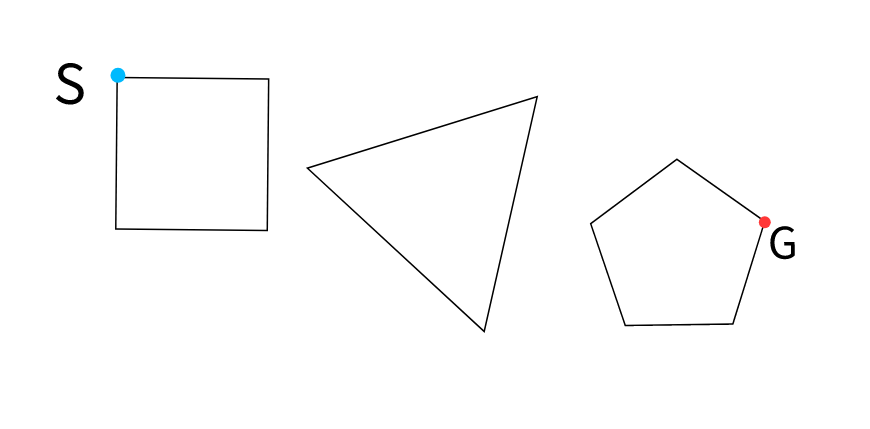

Setting up the environment in python:

In [3]:
#Graph for previous picture
initNodes = {
    'SQ1': {'SQ2': 2, 'SQ3': 2},
    'SQ2': {'SQ1': 2, 'SQ4': 2, 'T1': 6, 'T2': 8},
    'SQ3': {'SQ1': 2, 'SQ4': 2, 'T3': 10},
    'SQ4': {'SQ2': 2, 'SQ3': 2, 'T1': 3, 'T3': 6},
    'T1': {'T2': 4, 'T3': 4, 'SQ2': 6, 'SQ4': 3},
    'T2': {'T1': 4, 'T3': 4, 'SQ2': 10, 'H1': 5, 'H5': 4},
    'T3': {'T1': 4, 'T2': 2, 'H4': 3, 'H5': 6},
    'H1': {'H2': 3, 'H5': 3, 'T2': 7},
    'H2': {'H1': 3, 'H3': 3},
    'H3': {'H2': 3, 'H4': 4},
    'H4': {'H3': 3, 'H5': 4, 'T3': 3},
    'H5': {'H1': 3, 'H4': 4, 'T2': 4, 'T3': 6}
}

#Create graph
graphObstacles = Graph(initNodes)

#Define graph problem
problemObstacles = GraphProblem('T1', 'H2', graphObstacles)

#A* search with previous problem
star = astar_search(problem=problemObstacles, h=problemObstacles.h, display=True)


7 paths have been expanded and 2 paths remain in the frontier


### Missionaries and Cannibals

The missionaries and cannibals problem states that there is a river with six people in total, three missionaries and three cannibals. They have a boat that only allows 2 people to ride on it at a time. The people have to cross to the other side, however, the missionaries must not be outnumbered by the cannibals.

For this problem, we assume several rules: If two people enter and exit the boat, they don't wait on each other and do the action at the same time. The boat starts on the same side of the river as the six people, the boat must have a passenger on board in order to cross the river, and backtracking (returning to a previous state is not allowed)

States where cannibals outnumber missionaries are ignored. Drawing the state space: The two river banks are represented by A and B, the cannibals are colored red, while the missionaries are black.

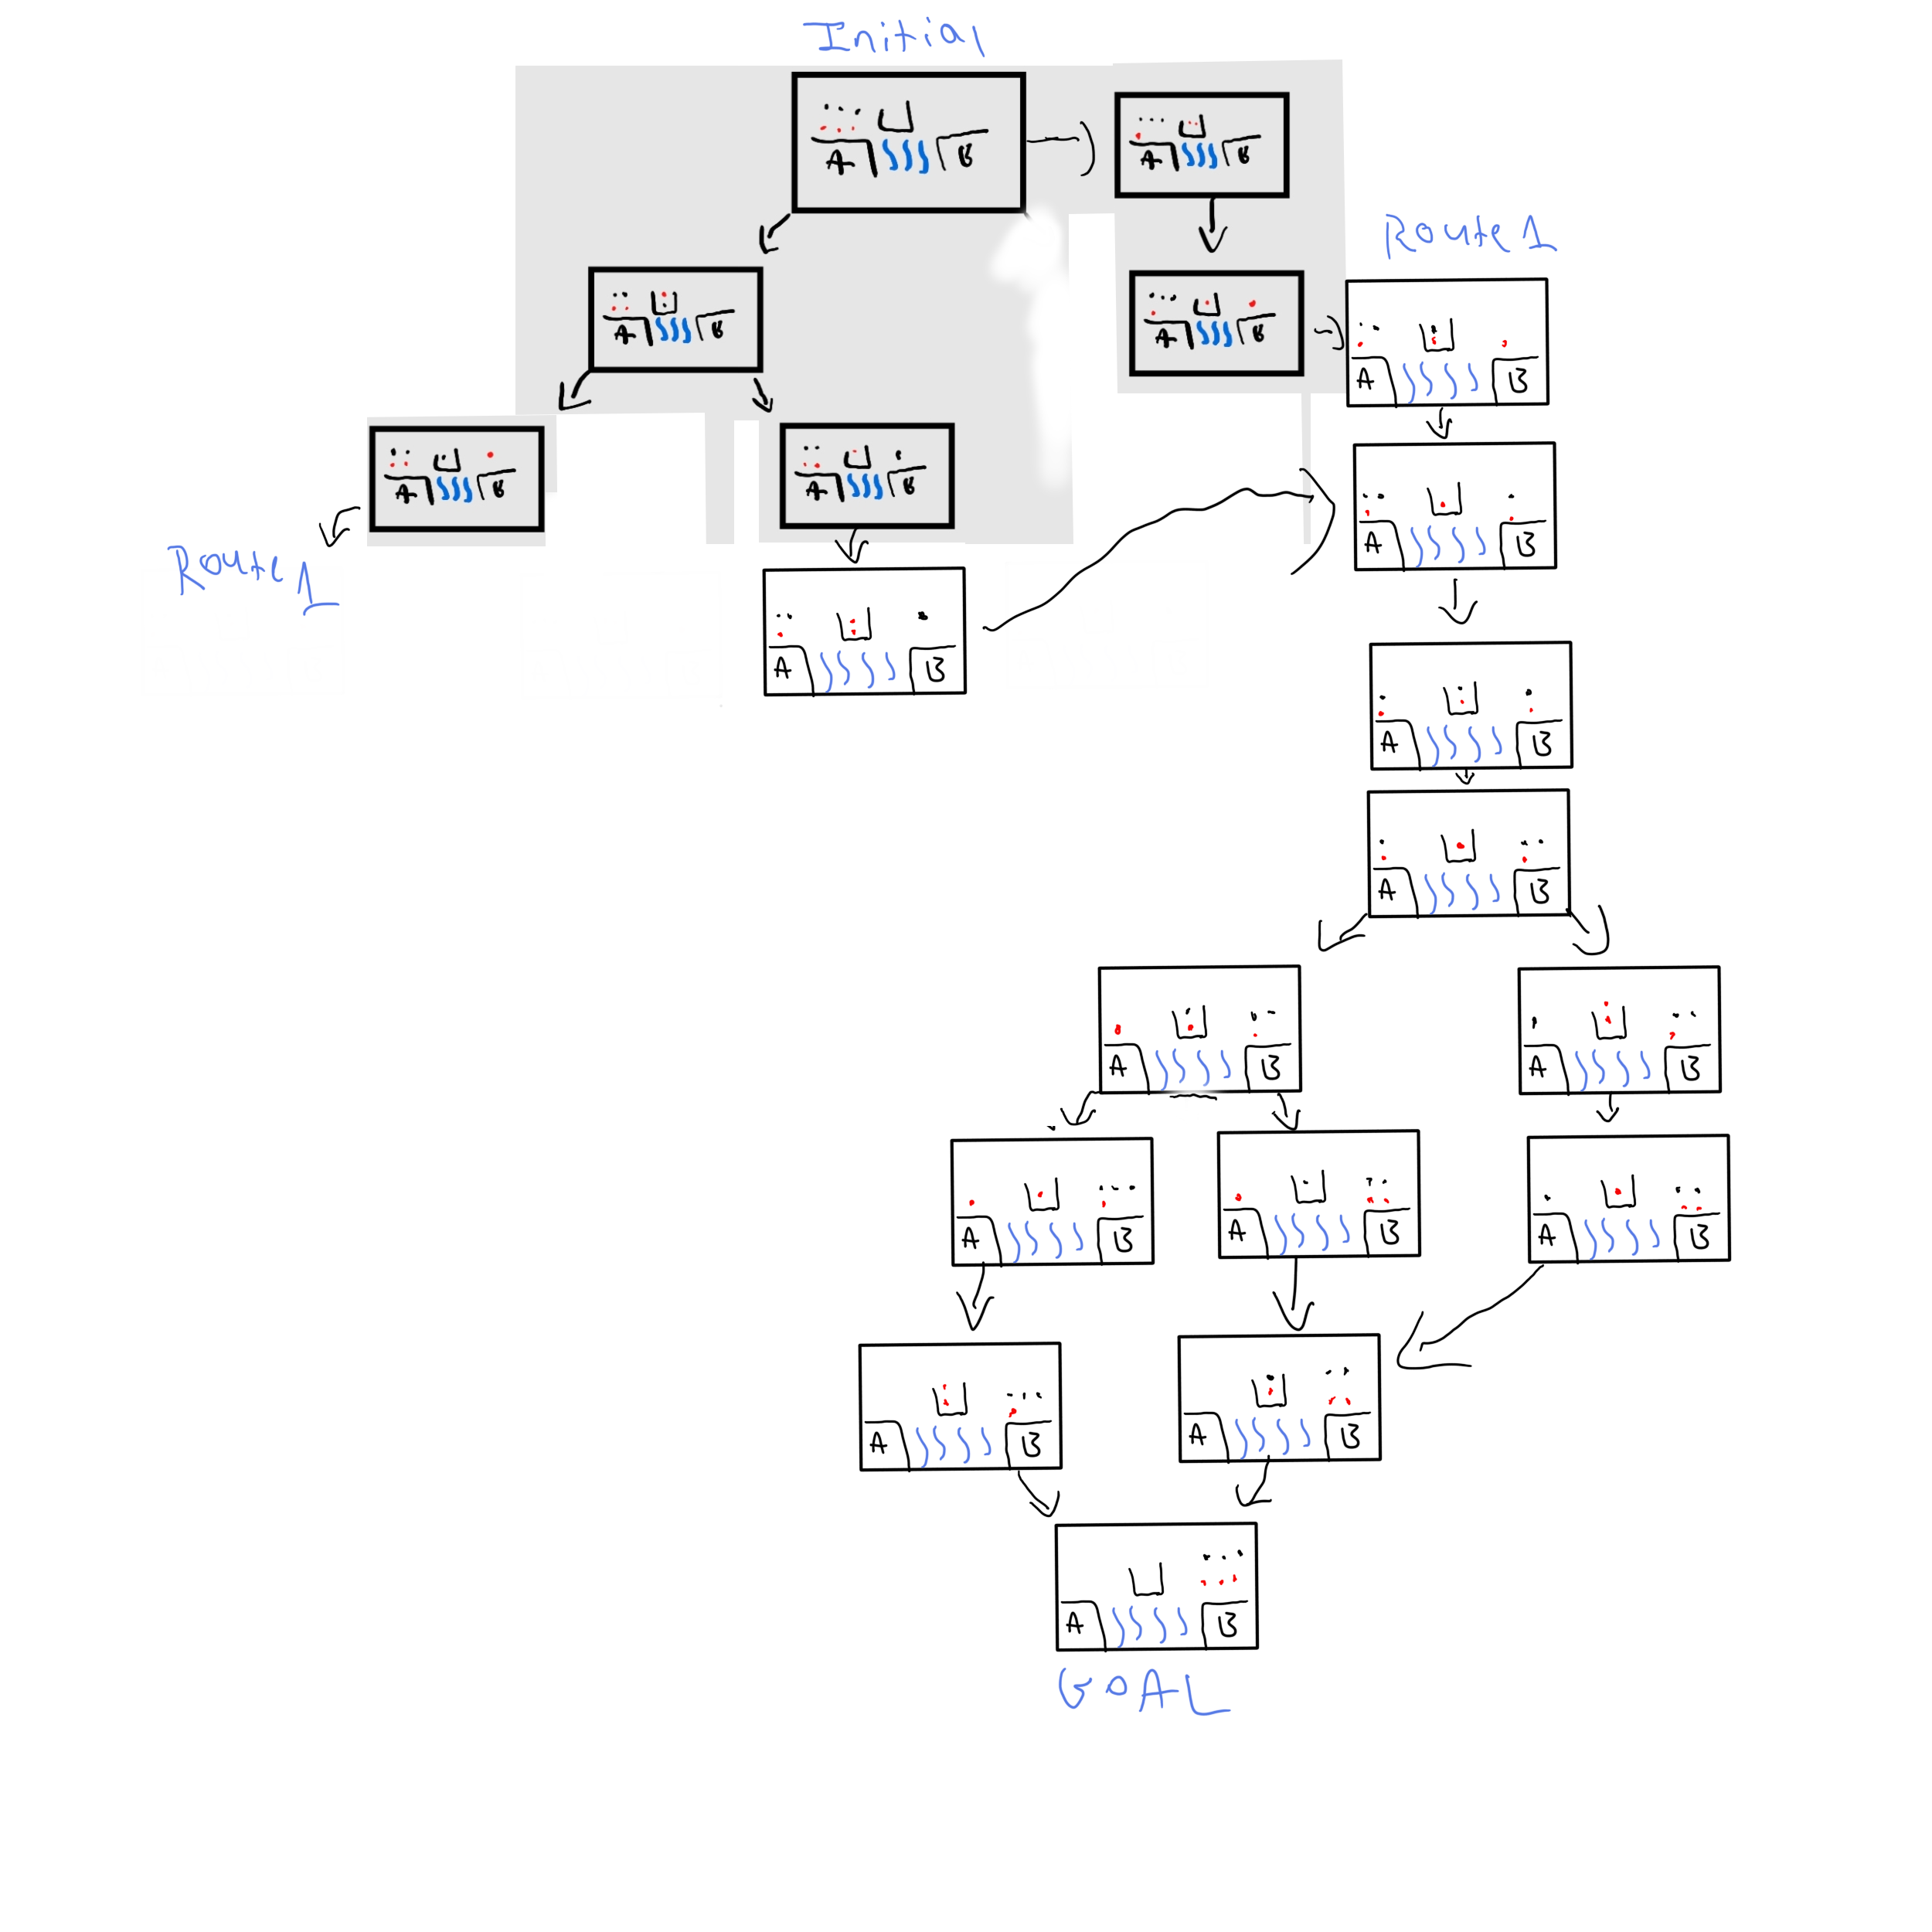

Solving the environment optimally, we would need to use Depth-First Search, since the deepest node has to be the solution because there is only one goal state.

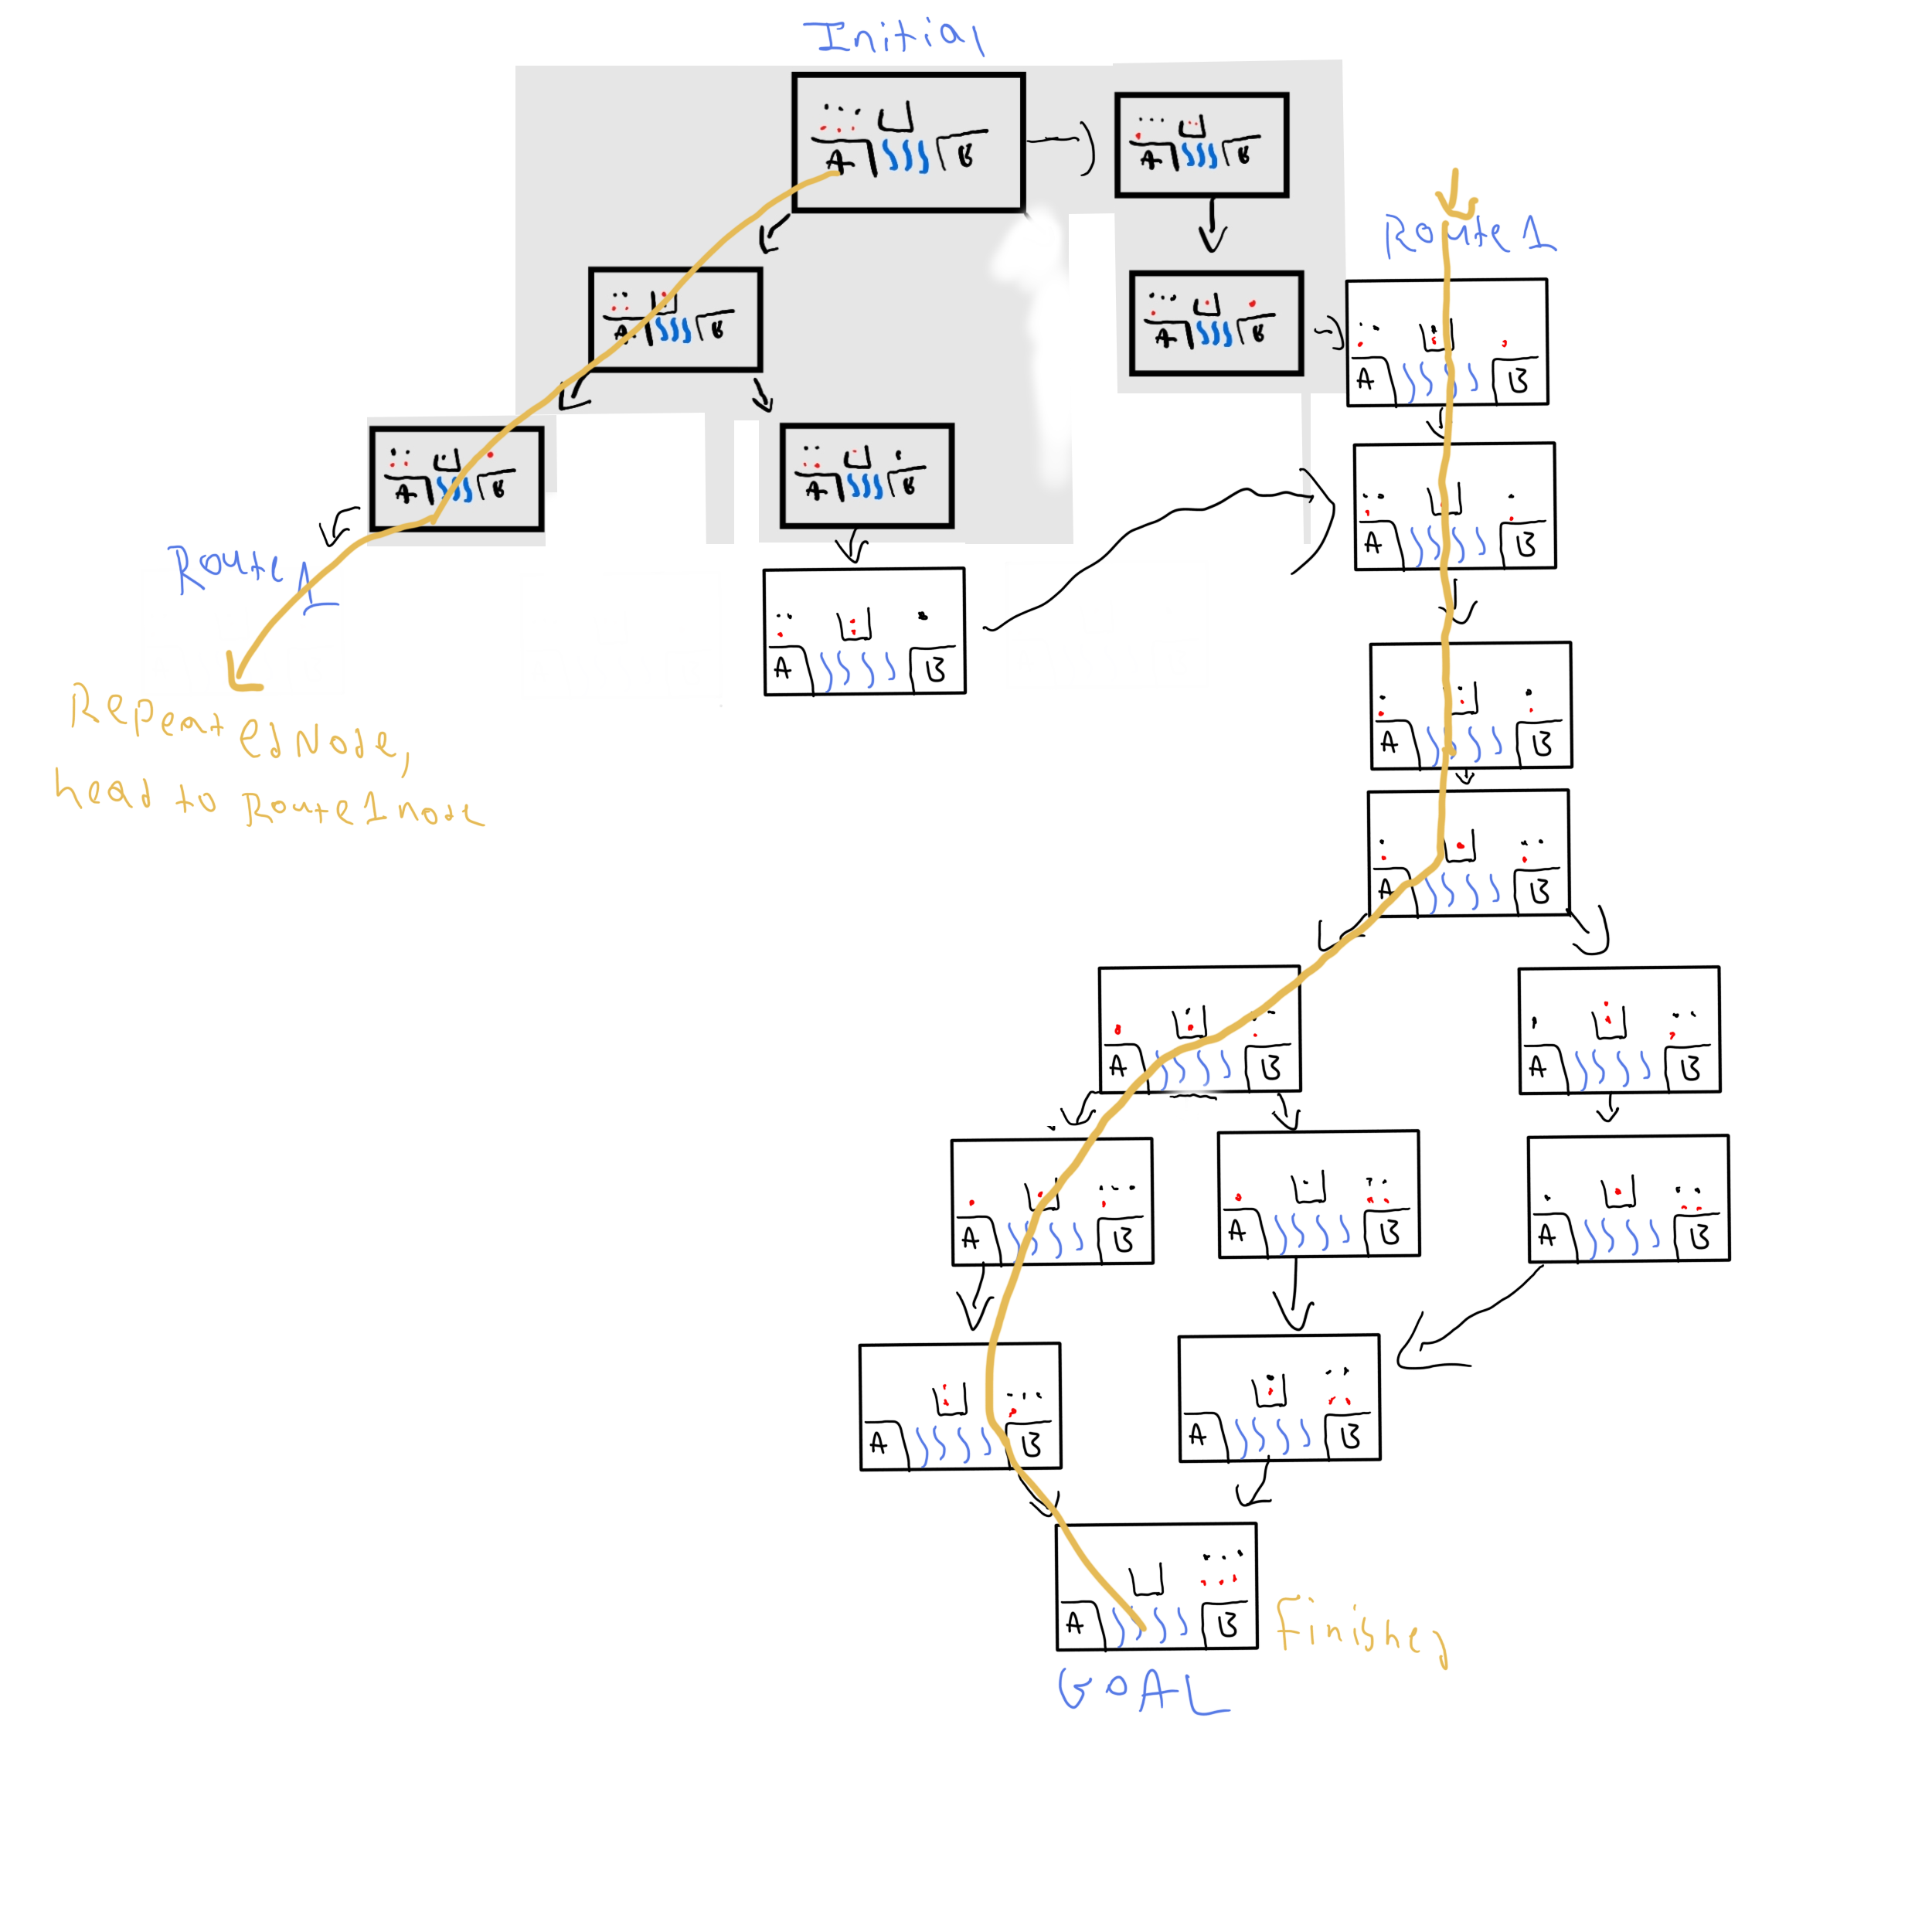

In this problem, it's a good idea to check for repeated states because the number of possible valid moves are limited and space can be saved by not duplicating state nodes that are exactly the same. In another case, if we were to include all the possible moves that are possible, by allowing backtracking, using depth-first search without checking for repeated states could cause an infinite loop, since there would be branches with infinite depth.

People have a hard time solving this puzzle since by thinking humanly, it can be very challenging to think ahead and avoid having cannibals outnumbering the missionaries, especially without a pen and paper to keep track of where the missionaries and cannibals are.

## Conclusion

In Conclusion, We learned to solve simple search problems by designing and implementing search algorithms.